In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV,ElasticNetCV
from pyentrp import entropy as pyent
import EntropyHub as EH
import neurokit2 as nk
import random
import sampen
import requests
import io
import apache_log_parser
from pprint import pprint
import os
from sklearn import preprocessing
import itertools
import hurst
import math


In [2]:
from typing import List

df_S = pd.read_csv(f"{os.getcwd()}/nasa_data_JulAug.csv")
df_S["date"] = pd.to_datetime(df_S["date"])
df_S


,Unnamed: 0,date,count
0,0,1995-07-01 00:00:01,1
1,1,1995-07-01 00:00:02,0
2,2,1995-07-01 00:00:03,0
3,3,1995-07-01 00:00:04,0
4,4,1995-07-01 00:00:05,0
...,...,...,...
5356788,5356788,1995-08-31 23:59:49,3
5356789,5356789,1995-08-31 23:59:50,0
5356790,5356790,1995-08-31 23:59:51,0
5356791,5356791,1995-08-31 23:59:52,2


In [106]:
df_6S = df_S.groupby(pd.Grouper(key="date", freq="6S")).sum()[145000:190000].reset_index()
df_6S

,date,Unnamed: 0,count
0,1995-07-11 01:40:00,5220009,3
1,1995-07-11 01:40:06,5220045,4
2,1995-07-11 01:40:12,5220081,3
3,1995-07-11 01:40:18,5220117,5
4,1995-07-11 01:40:24,5220153,6
...,...,...,...
44995,1995-07-14 04:39:30,6839829,4
44996,1995-07-14 04:39:36,6839865,6
44997,1995-07-14 04:39:42,6839901,2
44998,1995-07-14 04:39:48,6839937,2


In [107]:
df_6S_date = (pd.to_datetime(df_6S["date"]).astype(int) / 10**9).array.reshape(-1, 1)
df_6S_count = df_6S["count"].array.reshape(-1, 1)

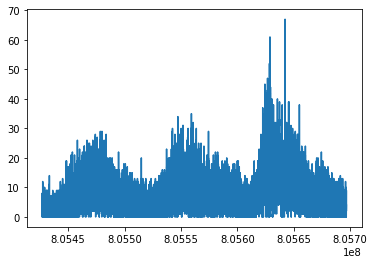

In [108]:
plt.plot(df_6S_date, df_6S_count)

In [78]:
def compute_enet(x_train, y_train, alpha = 1.0, l1_ratio = 0.5) -> ElasticNet:
    return ElasticNet(alpha=alpha, l1_ratio=l1_ratio).fit(x_train, y_train)

In [12]:
def enet_loop(x, y, alpha = 1.0, l1_ratio = 0.5, batch_size = 9):
    y_pred = pd.DataFrame([])
    for index in range(int(x.size))[batch_size:]:
        try:
            x_train = x[index-batch_size:index]
            y_train = y[index-batch_size:index]
            x_test = x[index+1].reshape(-1, 1)
            enet = compute_enet(x_train, y_train, alpha, l1_ratio)
            target_y_pred = enet.predict(x_test)
            y_pred = y_pred.append(pd.DataFrame(target_y_pred), ignore_index=True)
        except Exception as e:
            print(e)
    return y_pred

In [109]:
df_6S_y_pred  = enet_loop(x = df_6S_date, y = df_6S_count)

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_2691/857213799.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_2691/857213799.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_2691/857213799.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_2691/857213799.py:10: FutureWarning: The frame.append method is deprecated and w

KeyboardInterrupt: 

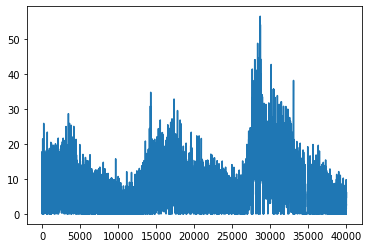

In [80]:
plt.plot(df_6S_y_pred.applymap(lambda y: 0 if y < 0 else y))

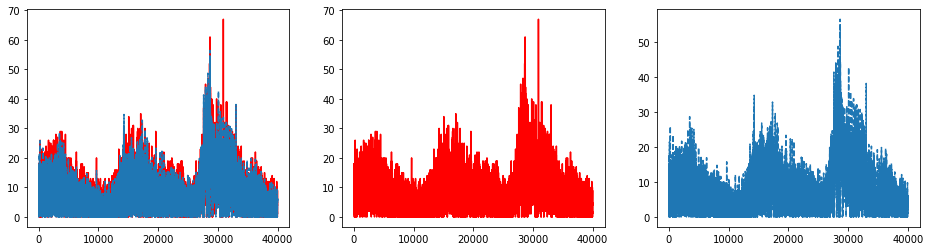

In [81]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
axes[0].plot(df_6S_count[9:], color='red')
axes[0].plot(df_6S_y_pred.applymap(lambda x: 0 if x < 0 else x), linestyle="dashed")
axes[1].plot(df_6S_count[9:], color='red')
axes[2].plot(df_6S_y_pred.applymap(lambda x: 0 if x < 0 else x), linestyle="dashed")

In [138]:
def blocken(ser, trunk_size) -> List[float]:
    past = 0.
    results = []
    for y in ser:
        current_ceiled = math.ceil(y / trunk_size)
        past_ceiled = math.ceil(past / trunk_size)
        if current_ceiled == past_ceiled-1 | current_ceiled == past_ceiled+1:
            current_ceiled = past_ceiled
        current_result = current_ceiled * trunk_size
        results = results + [current_result]
        past = current_result
    return results

In [34]:
def df_to_list(df: pd.DataFrame)-> np.ndarray:
    return np.array(list(itertools.chain.from_iterable(df.to_numpy())))

In [82]:
blocked_df_6S_count = blocken(df_to_list(df_6S_count), 15)

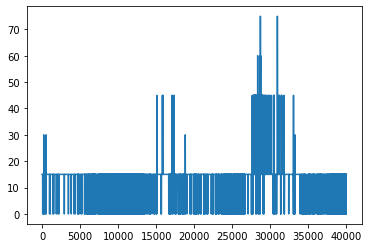

In [83]:
plt.plot(blocked_df_6S_count)

In [230]:
df_6S_date = (pd.to_datetime(df_6S["date"]).astype(int) / 10**9).array.reshape(-1, 1)
df_6S_count = df_6S["count"].array.reshape(-1, 1)
rolled_df_6S_count = df_6S["count"].rolling(2000).max().fillna(0).array.reshape(-1, 1)

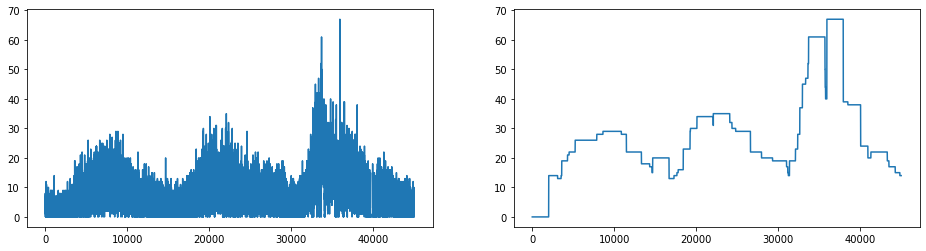

In [231]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].plot(df_6S_count)
axes[1].plot(rolled_df_6S_count)

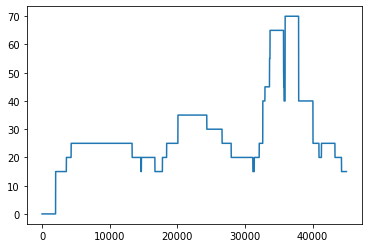

In [236]:
blocked_df_6S_count = blocken(df_to_list(rolled_df_6S_count),5)
plt.plot(blocked_df_6S_count)

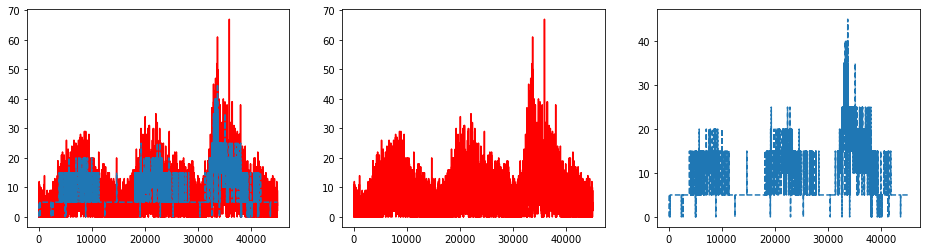

In [156]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
axes[0].plot(df_6S_count[9:], color='red')
axes[0].plot(blocked_df_6S_count, linestyle="dashed")
axes[1].plot(df_6S_count[9:], color='red')
axes[2].plot(blocked_df_6S_count, linestyle="dashed")

In [93]:
import numpy as np
import pandas as pd
from scipy.linalg import hankel
from scipy.spatial.distance import pdist
from typing import List
import sys
import math

def disten(ser: List[float], m: int = 2, tau: int = 8 , B: int = 512) -> float:
    """
    @param ser: time-series (vector in a column)
    @param m: embedding dimension (scalar)
    @param tau: time delay (scalar)
    @param B: bin number for histogram (scalar)
    """

    # rescaling
    rescaled = [y / (max(ser) - min(ser) + sys.float_info.epsilon) for y in [x - min(ser) for x in ser]]

    # distance matrix
    N = len(rescaled) - (m - 1) * tau
    if N < 0:
        raise(f"ser is too short: {len(ser)}")
    ind = hankel(np.arange(1, N+1), np.arange(N, len(rescaled)+1))
    rnt = [[rescaled[z-1] for z in y] for y in [x[::tau] for x in ind]]
    dv = pdist(rnt, 'chebychev')

    # esimating probability density by histogram
    num = pd.cut(dv, np.linspace(0, 1, B), include_lowest=True).value_counts().to_numpy()
    freq = [x / num.sum() for x in num]

    # disten calculation
    prepared = [math.log2(y) for y in [x + sys.float_info.epsilon for x in freq]]
    return -sum([x * y for (x, y) in zip(prepared, freq)]) / math.log2(B)

In [161]:
def disten_loop(ser: List[float], batch_size = 100) -> List[float]:
    return [disten(ser[index:index+batch_size]) for index in range(len(ser[batch_size:]))]

In [227]:
df_6S_count_disten = disten_loop(df_to_list(rolled_df_6S_count), 100)

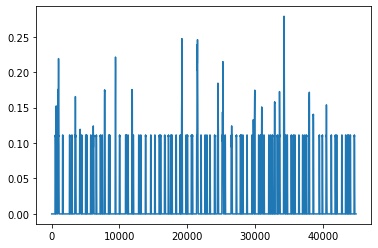

In [228]:
plt.plot(df_6S_count_disten)

In [197]:
def sampen_loop(ser: List[float], batch_size = 300) -> List[float]:
    return [nk.entropy_sample(np.array(ser[index-batch_size:index]))[0] for index in range(len(ser))[batch_size:]]

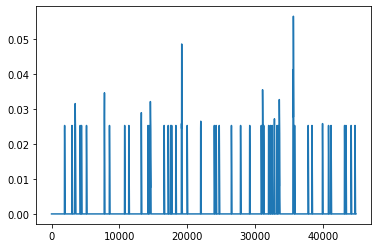

In [234]:
df_6S_count_sampen = sampen_loop(df_to_list(rolled_df_6S_count), batch_size=100)
plt.plot(df_6S_count_sampen)

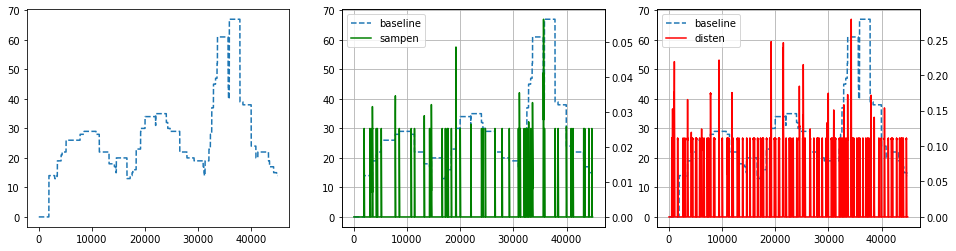

In [237]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
axes[0].plot(rolled_df_6S_count[100:],label='baseline', linestyle="dashed")

ln1 = axes[1].plot(rolled_df_6S_count[100:],label='baseline', linestyle="dashed")
ax1 = axes[1].twinx()
ln2 = ax1.plot(df_6S_count_sampen, color='green', label="sampen")

h1, l1 = axes[1].get_legend_handles_labels()
h2, l2 = ax1.get_legend_handles_labels()
axes[1].legend(h1+h2, l1+l2, loc='upper left')

axes[1].grid(True)

ln2 = axes[2].plot(rolled_df_6S_count[100:],label='baseline', linestyle="dashed")
ax2 = axes[2].twinx()
ln2=ax2.plot(df_6S_count_disten, color='red', label="disten")

h1, l1 = axes[2].get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
axes[2].legend(h1+h2, l1+l2, loc='upper left')

axes[2].grid(True)

In [189]:
blocked_df_6S_count_disten = disten_loop(blocked_df_6S_count, 100)

In [190]:
blocked_df_6S_count_disten

[0.05347701881079852,
 0.0462698317855916,
 0.03803183432135583,
 0.028431561583621257,
 0.016788552279679222,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5593627820165746e-17,
 -3.5

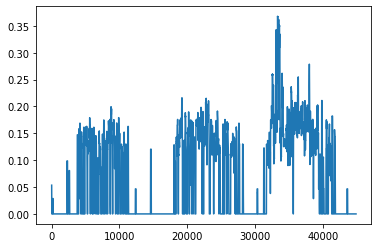

In [195]:
plt.plot(blocked_df_6S_count_disten)

In [150]:
def sampen_loop(ser: List[float], batch_size = 300) -> List[float]:
    return [nk.entropy_sample(np.array(ser[index-batch_size:index]))[0] for index in range(len(ser))[batch_size:]]

In [146]:
len(blocked_df_6S_count)

45000

In [183]:
blocked_df_6S_count_sampen = sampen_loop(blocked_df_6S_count, batch_size=100)

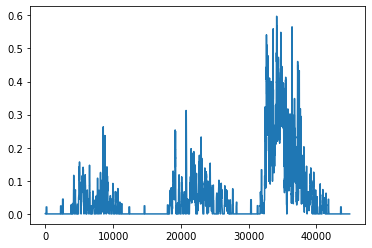

In [184]:
plt.plot(blocked_df_6S_count_sampen)

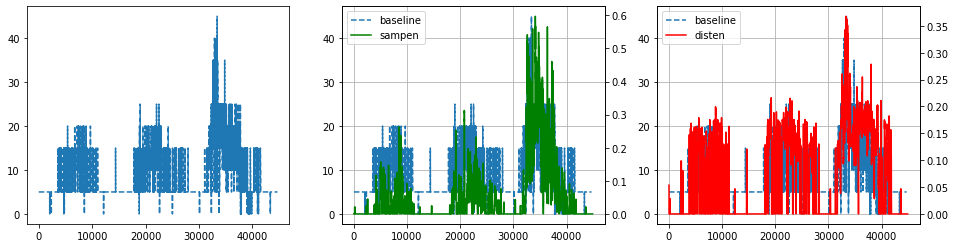

In [192]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
axes[0].plot(blocked_df_6S_count[300:],label='baseline', linestyle="dashed")

ln1 = axes[1].plot(blocked_df_6S_count[300:],label='baseline', linestyle="dashed")
ax1 = axes[1].twinx()
ln2 = ax1.plot(blocked_df_6S_count_sampen, color='green', label="sampen")

h1, l1 = axes[1].get_legend_handles_labels()
h2, l2 = ax1.get_legend_handles_labels()
axes[1].legend(h1+h2, l1+l2, loc='upper left')

axes[1].grid(True)

ln2 = axes[2].plot(blocked_df_6S_count[300:],label='baseline', linestyle="dashed")
ax2 = axes[2].twinx()
ln2=ax2.plot(blocked_df_6S_count_disten, color='red', label="disten")

h1, l1 = axes[2].get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
axes[2].legend(h1+h2, l1+l2, loc='upper left')

axes[2].grid(True)

In [259]:
df_6S_date = (pd.to_datetime(df_6S["date"]).astype(int) / 10**9).array.reshape(-1, 1)
df_6S_count = df_6S["count"].array.reshape(-1, 1)
rolled_df_6S_count = df_6S["count"].rolling(60).max().fillna(0).array.reshape(-1, 1)

In [260]:
rolled_df_6S_count.size

45000

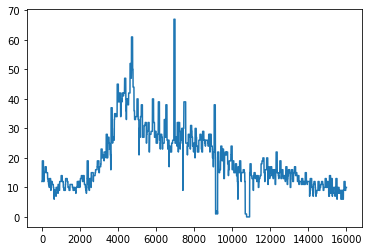

In [261]:
plt.plot(rolled_df_6S_count[29000:])

In [246]:
### Range distance for RangeEn_B and RangeEn_A
def dist_range(x, y):
  return (np.max(np.abs(x - y), axis=1) - np.min(np.abs(x - y), axis=1)) / (np.max(np.abs(x - y), axis=1) + np.min(np.abs(x - y), axis=1))

### RangeEn-A (mApEn)
def RangeEn_A(x, emb_dim=2, tolerance=.2, dist=dist_range):

    n = np.shape(x)
    n = np.max(n)

    tVecs = np.zeros((n - emb_dim, emb_dim + 1))
    for i in range(tVecs.shape[0]):
        tVecs[i, :] = x[i:i + tVecs.shape[1]]
    counts = []
    for m in [emb_dim, emb_dim + 1]:
        # get the matrix that we need for the current m
        tVecsM = tVecs[:n - m + 1, :m]
        # successively calculate distances between each pair of template vectors
        C = []
        for i in range(len(tVecsM)):
            dsts = dist(tVecsM, tVecsM[i])
            # delete undefined distances coming from zero segments
            # dsts = [x for i, x in enumerate(dsts) if not np.isnan(x) and not np.isinf(x)]
            # count how many 'defined' distances are smaller than the tolerance
            # if(dsts):
            C.append((np.sum(dsts < tolerance)) / (n - m))
        # compute sum of log probabilities
        counts.append((np.sum(np.log(C))) / (n - m))

    RangeEn_A = counts[0] - counts[1]

    return RangeEn_A

##### RangeEn-B (mSampEn)
def RangeEn_B(x, emb_dim=2, tolerance=.2, dist=dist_range):

    n = np.shape(x)
    n = np.max(n)

    tVecs = np.zeros((n - emb_dim, emb_dim + 1))
    for i in range(tVecs.shape[0]):
        tVecs[i, :] = x[i:i + tVecs.shape[1]]
    counts = []
    for m in [emb_dim, emb_dim + 1]:
        counts.append(0)
        # get the matrix that we need for the current m
        tVecsM = tVecs[:n - m + 1, :m]
        # successively calculate distances between each pair of template vectors
        for i in range(len(tVecsM)):
            dsts = dist(tVecsM, tVecsM[i])
            # delete self-matching
            dsts = np.delete(dsts, i, axis=0)
            # delete undefined distances coming from zero segments
            # dsts = [x for i, x in enumerate(dsts) if not np.isnan(x) and not np.isinf(x)]
            # count how many 'defined' distances are smaller than the tolerance
            # if (dsts):
            counts[-1] += np.sum(dsts < tolerance)/(n - m - 1)

    if counts[1] == 0:
        # log would be infinite => cannot determine RangeEn_B
        RangeEn_B = np.nan
    else:
        # compute log of summed probabilities
        RangeEn_B = -np.log(1.0 * counts[1] / counts[0])

    return RangeEn_B

def rangenb_loop(ser: List[float], batch_size = 300) -> List[float]:
    return [RangeEn_B(np.array(ser[index-batch_size:index])) for index in range(len(ser))[batch_size:]]

def df_to_list(df: pd.DataFrame)-> np.ndarray:
    return np.array(list(itertools.chain.from_iterable(df.to_numpy())))

In [262]:
rangeb_rolled_df_6S_count = rangenb_loop(df_to_list(rolled_df_6S_count[29000:]))

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_2691/3277012288.py:3: RuntimeWarning: invalid value encountered in true_divide
  return (np.max(np.abs(x - y), axis=1) - np.min(np.abs(x - y), axis=1)) / (np.max(np.abs(x - y), axis=1) + np.min(np.abs(x - y), axis=1))


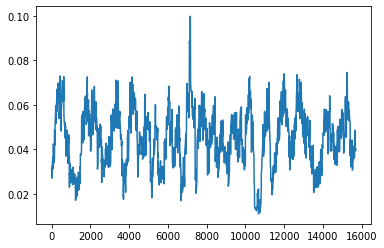

In [263]:
plt.plot(rangeb_rolled_df_6S_count)

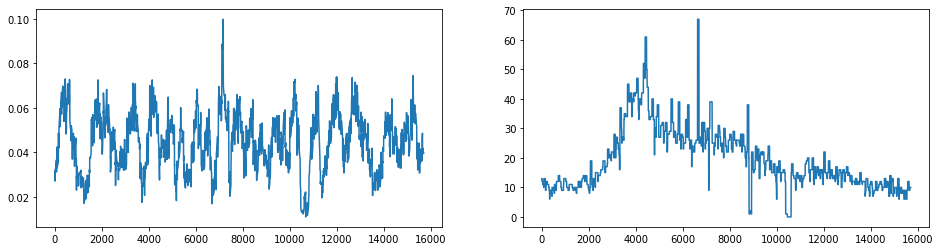

In [264]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

axes[0].plot(rangeb_rolled_df_6S_count)
axes[1].plot(rolled_df_6S_count[29300:])

In [267]:
df_M = df_S.groupby(pd.Grouper(key="date", freq="min")).sum().reset_index()
df_M

,date,Unnamed: 0,count
0,1995-07-01 00:00:00,1711,42
1,1995-07-01 00:01:00,5310,61
2,1995-07-01 00:02:00,8910,57
3,1995-07-01 00:03:00,12510,71
4,1995-07-01 00:04:00,16110,70
...,...,...,...
89275,1995-08-31 23:55:00,321391710,30
89276,1995-08-31 23:56:00,321395310,38
89277,1995-08-31 23:57:00,321398910,16
89278,1995-08-31 23:58:00,321402510,17


In [275]:
df_M_date = (pd.to_datetime(df_M["date"]).astype(int) / 10**9).array.reshape(-1, 1)
df_M_count = df_M["count"].array.reshape(-1, 1)
rolled_df_M_count = df_M["count"].rolling(60).max().fillna(0).array.reshape(-1, 1)

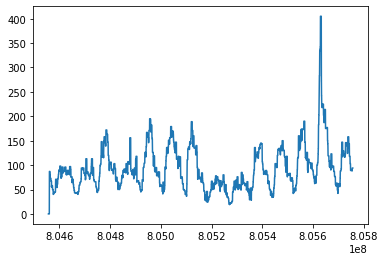

In [276]:
plt.plot(df_M_date[:20000], rolled_df_M_count[:20000])

In [277]:
rangeb_rolled_df_M_count = rangenb_loop(df_to_list(rolled_df_M_count[:20000]))

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_2691/3277012288.py:3: RuntimeWarning: invalid value encountered in true_divide
  return (np.max(np.abs(x - y), axis=1) - np.min(np.abs(x - y), axis=1)) / (np.max(np.abs(x - y), axis=1) + np.min(np.abs(x - y), axis=1))


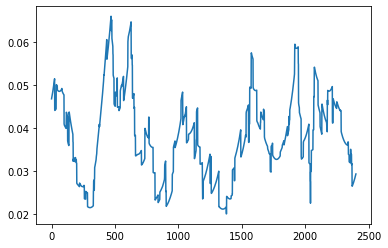

In [291]:
plt.plot(rangeb_rolled_df_M_count[17300:20000])

In [296]:
len(rangeb_rolled_df_M_count[17300:19300])

2000

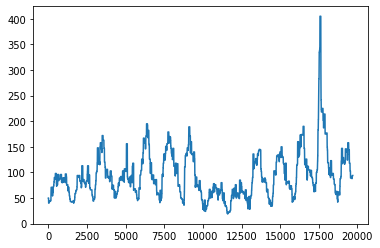

In [300]:
plt.plot(rolled_df_M_count[300:20000])

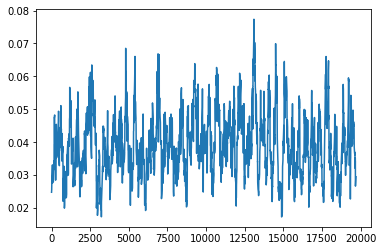

In [298]:
plt.plot(rangeb_rolled_df_M_count)